<a href="https://colab.research.google.com/github/gregorio-saporito/hate-speech-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining and Sentiment Analysis: Hate Speech Detection
Gregorio Luigi Saporito - DSE (2020-2021)

### Libraries

In [68]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import nltk
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import plot_confusion_matrix
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Upload the data to session storage
Upload here below the __labeled_data.csv__ file. The labels correspond to
- 0: hate speech
- 1: offensive language
- 2: neither

In [ ]:
# upload here the data
uploaded = files.upload()

Saving labeled_data.csv to labeled_data.csv


In [17]:
# read the csv file and rename the columns
fields = ['Unnamed: 0', 'class', 'tweet']
raw = pd.read_csv('labeled_data.csv', usecols=fields)\
  .rename(columns={"Unnamed: 0": "id", "class": "label"})

### Inspect the data

In [18]:
# snapshot of the first rows
raw.head()

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [19]:
# size of the dataset
raw.shape

(24783, 3)

In [20]:
# inspect the presence of missing values
print(
    'Check for null values\n' +
    str(raw.isnull().sum()) + '\n'
    'Check for na values\n' +
    str(raw.isna().sum())
)

Check for null values
id       0
label    0
tweet    0
dtype: int64
Check for na values
id       0
label    0
tweet    0
dtype: int64


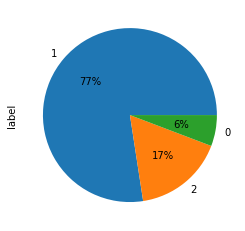

In [21]:
# inspect the classes' frequency
raw['label'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.show()

### Perform classification

In [24]:
dflearn = pd.DataFrame()
dflearn['target'] = raw['label']
dflearn['text'] = raw['tweet']
dflearn.head()

,target,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [27]:
# split the sample in train + test
X = dflearn[['text']]
y = dflearn['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Custom transformer

In [32]:
class CleanText( BaseEstimator, TransformerMixin ):
    
    def __init__( self, lang = "english"):
        self.lang = lang
        self.stemmer = SnowballStemmer(self.lang)
      
    def fit( self, X, y = None ):
        return self 
    
    def clean( self, x ):
        string = pd.Series(x.lower()).str.replace('[^\w\s]','',regex=True)[0]
        words = [w for w in nltk.word_tokenize(string)]
        return " ".join(words).strip()
    
    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

In [37]:
# test method in the class
cl = CleanText()
cl.transform(X_train)

22893              why is this bitch throwing condoms lmao
18933    rt dsrtvet foxnews tjoy7 and i dont have any c...
18541    rt alicia_garcia3 thats why god made brownies ...
11578                       if thats yo hoe thats my hoe 2
7699     am sorry i cant stand stand some black females...
                               ...                        
21575    the last atbat at yankee stadium thanks for ma...
5390     _bradleey lmfaoooo yooo i lost my elevator pas...
860      pornandroidiphoneipadsexxxx anal hardcore brit...
15795    rt jennyjohnsonhi5 just when i thought justin ...
23654    bitches ain8217t shit and they ain8217t saying...
Name: text, Length: 12391, dtype: object

### Custom feature extraction
Adding extra features like the length of the reviews, punctuation elements, and some granular elements of punctuation like exclamation marks

In [38]:
class CustomFeatures( BaseEstimator, TransformerMixin ):
    
    # Class Constructor 
    def __init__( self ):
        return
    
    # Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
        
    # Method that describes what we need this transformer to do i.e.
    # returning length and punctuations in the 'text' column in data frame
    def transform( self, X, y = None ):
        f           = pd.DataFrame()
        f['len']    = X['text'].str.len()
        f['punct']  = X['text'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
        f['excl']  = X['text'].str.findall(r'!').str.len()
        return f[['len','punct','excl']]

In [39]:
# testing the method transform of the custom features
obj = CustomFeatures()
obj.transform(X_train)

,len,punct,excl
22893,40,1,0
18933,146,9,1
18541,68,7,0
11578,36,5,0
7699,137,1,0
...,...,...,...
21575,117,10,0
5390,164,15,0
860,109,19,0
15795,146,6,0


### Pipeline

In [49]:
pipe = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                               ('tfidf', TfidfVectorizer())])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2)),
                 ("scale", StandardScaler(with_mean = False))])

In [52]:
pipe_logistic = Pipeline([('pre_process', pipe),
                          ('classify', LogisticRegression())])

In [53]:
# Fit on training
pipe_logistic.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pre_process',
                 Pipeline(memory=None,
                          steps=[('extract',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('terms',
                                                                  Pipeline(memory=None,
                                                                           steps=[('clean',
                                                                                   CleanText(lang='english')),
                                                                                  ('tfidf',
                                                                                   TfidfVectorizer(analyzer='word',
                                                                                                   binary=False,
                                                                                                   decode_error='st

In [63]:
# Evaluate on test
y_pred = pipe_logistic.predict(X_test)
y_true = y_test

In [66]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[  59  633   51]
 [  57 9282  219]
 [   1 1263  827]]
Normalized confusion matrix
[[7.94e-02 8.52e-01 6.86e-02]
 [5.96e-03 9.71e-01 2.29e-02]
 [4.78e-04 6.04e-01 3.96e-01]]


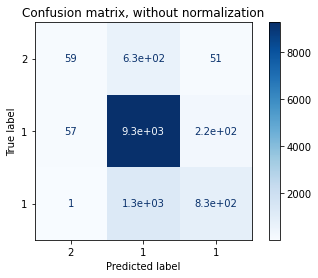

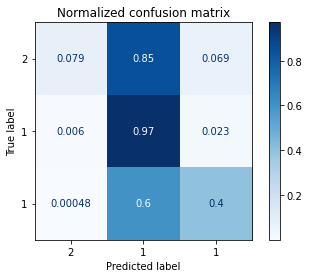

In [71]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe_logistic, X_test, y_test,
                                 display_labels=y,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()